<a href="https://colab.research.google.com/github/subhdeepkaur/comp215/blob/main/labs/lab04-more_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 4
----------------
#### Name(s):
#### Date:

By the end of this lab you should be able to:
  * use composition and inheritance in a `class` to categorize related information


During this lab, you will be introduced to the following:
  * something, something



## Near Earth Objects (with more classes)

We'll continue working with Near Earth Object data using NASA's API: https://api.nasa.gov/.  In Lab 3 we defined an Asteroid class that contained a simple data structure.  In this lab, we will be Here's a brief review from Lab 2 on how to use the API.  

In [64]:
# import necessary modules
import datetime, json, requests
from pprint import pprint
from datetime import datetime
from typing import List
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


### Review: make an API query

Here's a query that gets the record for a single NEO that recently passed by.

In [65]:
#API_KEY = 'DEMO_KEY'  # substitute your API key here
API_KEY = 'QMU73gySBTeUk6FVRje8eMwNOFfI1FZOwRtlf0Xo'

def get_neos(start_date):
    """ Return a list of NEO for the week starting at start_date """
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&api_key={API_KEY}'
    # Fetch last week's NEO feed
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    #pprint(data)
    print(f'{data["element_count"]} Near Earth Objects found for week of {start_date}')
    return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records ]

def get_neo(id):
    """ Return a NEO record for the given id """
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    return json.loads(response.text)

week_start = '2023-01-15'
neos = get_neos(week_start)
assert len(neos) > 0, f'Oh oh!  No NEOs found for {week_start}'
neo = get_neo(neos[-1]['id'])  # get the very latest NEO
print(f"Record for NEO ID {neos[-1]['id']} is:")
pprint(neo)

117 Near Earth Objects found for week of 2023-01-15
Record for NEO ID 54339874 is:
{'absolute_magnitude_h': 24.86,
 'close_approach_data': [{'close_approach_date': '1949-07-04',
                          'close_approach_date_full': '1949-Jul-04 22:19',
                          'epoch_date_close_approach': -646710060000,
                          'miss_distance': {'astronomical': '0.419726307',
                                            'kilometers': '62790161.51016609',
                                            'lunar': '163.273533423',
                                            'miles': '39015997.166588442'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '73509.6739172087',
                                                'kilometers_per_second': '20.4193538659',
                                                'miles_per_hour': '45676.0526626122'}},
                         {'close_approach_date': '1950-0

## Exercise 1: Define a CloseApproach class

Each NEO record comes with a list of `close_approach_data`, where each record in this list represents a single “close approach” to another orbiting body.
1. Develop a class named `CloseApproach` to represent a single close approach record.  State variables are

        neo (refrence to related NEO object)
        orbiting body (str)
        approach date (datetime object!)
        miss distance (float - choose units, document it, and be consistent!)
        relative velocity (ditto)
  
2. Define a "Factory" class method to construct a `CloseApproach` object from one close approach data record (a dictionary object). This method takes a `neo` object as input for the NEO to which the close approach data belongs. Remember to parse the date/time string into a datetime object.

In [66]:
# Ex. 1 your code here

class CloseApproach:
    """Represents a single close approach of an NEO to an orbiting body."""

    def __init__(self, neo : str, orbiting_body : str, approach_date : datetime, miss_distance : float, relative_velocity : float):
        """
        Initialize a CloseApproach object.
        """
        self.neo = neo
        self.orbiting_body = orbiting_body
        self.approach_date = approach_date
        self.miss_distance = float(miss_distance)  # in kilometers
        self.relative_velocity = float(relative_velocity)  # in km/s

    @classmethod
    def from_dict(cls, neo, data):
        """
        Factory method to create a CloseApproach object from a dictionary.
        """
        approach_date = datetime.strptime(data["close_approach_date"], "%Y-%m-%d")
        miss_distance = data["miss_distance"]["kilometers"]
        relative_velocity = data["relative_velocity"]["kilometers_per_second"]
        return cls(neo, data["orbiting_body"], approach_date, miss_distance, relative_velocity)

    def __repr__(self):
        return (f"CloseApproach(NEO={self.neo}, OrbitingBody={self.orbiting_body}, Date={self.approach_date}, MissDist={self.miss_distance} km, Velocity={self.relative_velocity} km/s)")

## Exercise 2: Add list of CloseApproach objects to the Asteroid

Define an `Asteroid` class, like you did in Lab 3, but give the `Asteroid` list of “close approaches”.  This is called *composition* because each Asteroid object will be *composed* of CloseApproach objects (plus some other things).  There is bit of a catch-22 here because we need the `Asteroid` to construct the `CloseApproach` objects. The first two steps deal with that:

1. Add an instance variable to your Asteroid class with a default value of an empty list:

    ```
    close_approaches:list = []
    ```
      
2. In the Asteroid `from_NEO` factory, use a list comprehension to build the list of `CloseApproach` objects for the Asteroid instance, and then set the instance's `close_approaches` variable before returning it. Setting the value of an object's instance variables from outside the class is generally frowned upon - this is why we make the factory a method of the class itself.

3. Add a method to `Asteroid` to return the `CloseApproach` object for the nearest miss (ie. smallest `missed_distance`):
    ```
    def nearest_miss(self):
        ...
    ```

4. Add a method to the Asteroid class, `closest_earth_approach`, that returns the CloseApproach object that represents the closest approach the Asteroid makes to Earth.
    ```
    def closest_earth_approach(self):
        ...
    ```

Write some test code to demonstrate these new features.

In [67]:
# Ex. 2 your code here

class Asteroid:
    def __init__(self, neo: str, close_approaches: List[CloseApproach] = []):
        self.neo = neo
        self.close_approaches = close_approaches

    @classmethod
    def from_NEO(cls, neo: str, approach_data: List[dict]):
        """
        Factory method to create an Asteroid object from NEO data.
        approach_data is expected to be a list of dictionaries where each dictionary contains the approach details.
        """

        close_approaches = []
        for data in approach_data:
                close_approaches.append(
                    CloseApproach(
                        neo=neo,
                        orbiting_body=data.get("orbiting_body", "Unknown"),  # Default to "Unknown" if missing
                        approach_date=datetime.strptime(data["approach_date"], "%Y-%m-%d %H:%M:%S"),
                        miss_distance=float(data["miss_distance"]),  # Ensure it's a float
                        relative_velocity=float(data["relative_velocity"])  # Ensure it's a float
                    )
                )
        return cls(neo, close_approaches)

    def nearest_miss(self):
        """
        Returns the CloseApproach object with the smallest miss distance.
        """
        return min(self.close_approaches, key=lambda ca: ca.miss_distance, default=None)

    def closest_earth_approach(self):
        """
        Returns the CloseApproach object that represents the closest approach to Earth.
        """
        # Assuming the orbiting body is "Earth" in all approaches for this example
        earth_approaches = [ca for ca in self.close_approaches if ca.orbiting_body == "Earth"]
        return min(earth_approaches, key=lambda ca: ca.miss_distance, default=None)


# Example of usage:

approach_data = [
    {"orbiting_body": "Earth", "approach_date": "2025-01-29 12:00:00", "miss_distance": 0.1, "relative_velocity": 20.5},
    {"orbiting_body": "Mars", "approach_date": "2025-01-30 14:00:00", "miss_distance": 0.3, "relative_velocity": 18.5},
    {"orbiting_body": "Earth", "approach_date": "2025-02-01 16:00:00", "miss_distance": 0.05, "relative_velocity": 22.0},
]

# Create an Asteroid object
asteroid = Asteroid.from_NEO("NEO-123", approach_data)

# Get the closest miss
nearest_miss = asteroid.nearest_miss()
print("Nearest Miss:", nearest_miss)

# Get the closest approach to Earth
closest_earth_approach = asteroid.closest_earth_approach()
print("Closest Earth Approach:", closest_earth_approach)


Nearest Miss: CloseApproach(NEO=NEO-123, OrbitingBody=Earth, Date=2025-02-01 16:00:00, MissDist=0.05 km, Velocity=22.0 km/s)
Closest Earth Approach: CloseApproach(NEO=NEO-123, OrbitingBody=Earth, Date=2025-02-01 16:00:00, MissDist=0.05 km, Velocity=22.0 km/s)


## Exercise 3: Plot the Closest Approaches

Write a function that takes an Asteroid object as a parameter and makes a timeline plot of close approaches.  You may wish to use the `matplotlib.pyplot` `plot` object.  Here is an example of a timeline plot for the asteroid with neo id '54339874'

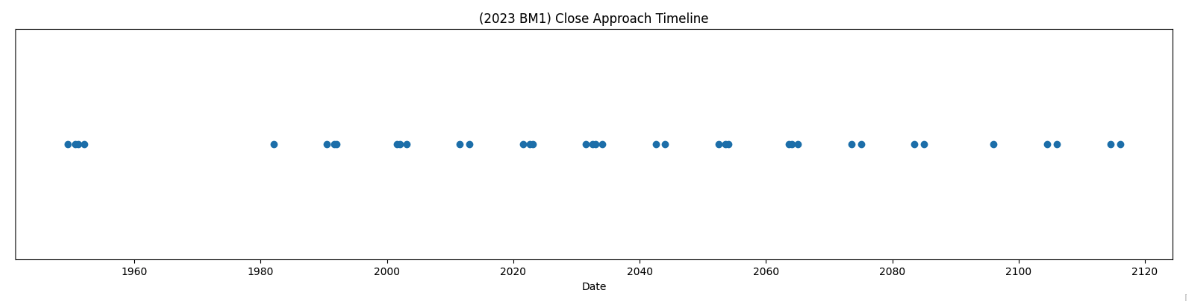

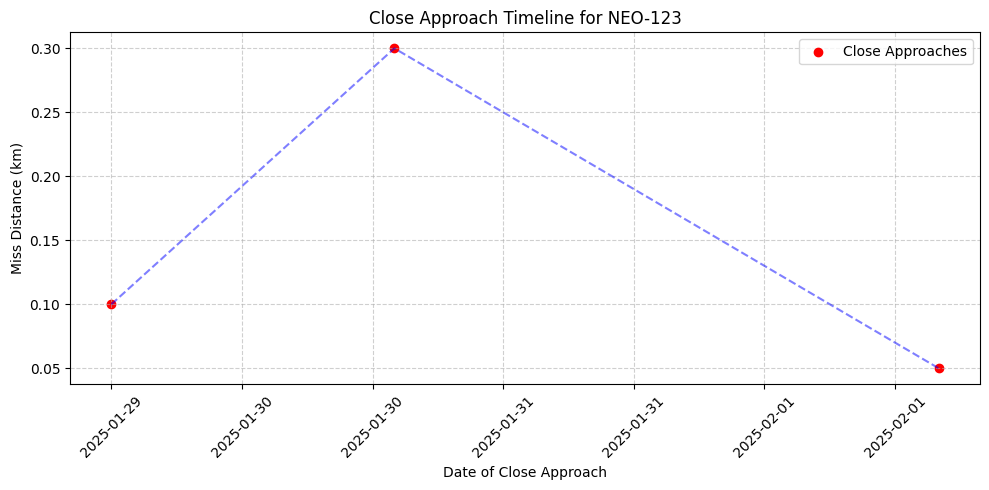

In [68]:
# Ex. 3 your code here


def plot_close_approaches(asteroid):
    """
    Plots a timeline of the close approaches of an asteroid.

    """
    if not asteroid.close_approaches:
        print(f"No close approach data available for {asteroid.name}.")
        return

    # Extract data
    dates = [ca.approach_date for ca in asteroid.close_approaches]
    miss_distances = [ca.miss_distance for ca in asteroid.close_approaches]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(dates, miss_distances, color='red', label='Close Approaches', marker='o')
    ax.plot(dates, miss_distances, linestyle='--', color='blue', alpha=0.5)

    # Formatting the timeline
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)

    # Labels and title
    ax.set_xlabel("Date of Close Approach")
    ax.set_ylabel("Miss Distance (km)")
    ax.set_title(f"Close Approach Timeline for {asteroid.neo}")
    ax.legend()

    # Grid and layout adjustments
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example Usage:
# Assuming `asteroid` is already created using Asteroid.from_NEO(...)
plot_close_approaches(asteroid)


## Challenge - Take your skills to the next level...

 With these data structures in place, we can now start answering all kinds of interesting questions about a single Asteroid or a set of Asteroids.  
Here’s a couple ideas to try:



* write a **function** named `most_dangerous_approach`, that takes a date range and returns a single “potentially hazardous” Asteroid object that makes the closest approach to Earth in within that range.  Your algorithm will ultimately need to:
    * grab the list of NEO’s for the given date range;
    * use a list comprehension to build the list of Asteroid objects for the NEO’s returned
    * use a list comprehension to filter  potentially hazardous Asteroids only;
    * use a list comprehension to map each Asteroid to its  closest_earth_approach
    * apply Python’s min function to identify the Asteroid with the closest_earth_approach

You may want to decompose some of these steps into smaller functions.
* add a method to the Asteroid class, estimated_mass, that computes an estimate of the Asteroid’s mass based on its diameter.  This is a model – state your assumptions.
* add a method to the CloseApproach class, impact_force,  that estimates the force of impact if the Asteroid hit the orbiting object.  Again, this is a model, state your assumptions.

In [69]:
# Ex. 5 (challenge) your code here

def most_dangerous_approach(start_date, end_date):
    """
    Finds the most dangerous asteroid (potentially hazardous) that makes the closest approach to Earth
    within a given date range.
    """
    # Fetch NEOs for the given date range
    url = f"https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&end_date={end_date}&api_key={API_KEY}"
    response = requests.get(url)
    data = response.json()

    if "near_earth_objects" not in data:
        print("No data available for the given range.")
        return None

    # Extract NEOs from the API response
    neos = [neo for date in data['near_earth_objects'].values() for neo in date]

